<a href="https://colab.research.google.com/github/SoYeonJ99/Breast-Cancer-Classification/blob/main/Cancernet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


# 1. Import Modules

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

# import keras
# from keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
# from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, SeparableConv2D


# 2. Cancernet 모델

In [ ]:
with tf.device('/device:GPU:0'):
  cancernet = Sequential()
  inputShape = (50, 50, 3)

  # CONV => RELU => POOL
  cancernet.add(SeparableConv2D(32, (3, 3), padding="same",
                                input_shape=inputShape))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(MaxPooling2D(pool_size=(2, 2)))
  cancernet.add(Dropout(0.25))

  # (CONV => RELU => POOL) * 2
  cancernet.add(SeparableConv2D(64, (3, 3), padding="same"))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(SeparableConv2D(64, (3, 3), padding="same"))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(MaxPooling2D(pool_size=(2, 2)))
  cancernet.add(Dropout(0.25))

  # (CONV => RELU => POOL) * 3
  cancernet.add(SeparableConv2D(128, (3, 3), padding="same"))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(SeparableConv2D(128, (3, 3), padding="same"))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(SeparableConv2D(128, (3, 3), padding="same"))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(MaxPooling2D(pool_size=(2, 2)))
  cancernet.add(Dropout(0.25))

  # first (and only) set of FC => RELU layers
  cancernet.add(Flatten())
  cancernet.add(Dense(256))
  cancernet.add(Activation("relu"))
  cancernet.add(BatchNormalization())
  cancernet.add(Dropout(0.5))

  # softmax classifier
  cancernet.add(Dense(2))
  cancernet.add(Activation("softmax"))

In [ ]:
cancernet.summary()

# 3. 데이터 불러오기

In [ ]:
X = np.load('/content/drive/MyDrive/b_cancer/X.npy') # images
Y = np.load('/content/drive/MyDrive/b_cancer/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
# 0과 1 사이로 스케일 조정

X_train = X_train / 255.0
# X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
y_train = to_categorical(y_train, num_classes = 2)
# y_val = to_categorical(y_val, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

#### 클래스 가중치 계산

In [ ]:
classTotals = y_train.sum(axis=0)
classTotals

array([1910., 1972.], dtype=float32)

In [ ]:
# loop over all classes and calculate the class weight
classWeight = dict()

for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]

classWeight

{0: 1.0324607, 1: 1.0}

*(4. Data Augmentation)*

In [ ]:
# # initialize the training data augmentation object
# trainAug = ImageDataGenerator(
#     	rotation_range=20,
#       zoom_range=0.05,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       shear_range=0.05,
#       horizontal_flip=True,
#       vertical_flip=True,
#       fill_mode="nearest")

# # initialize the validation (and testing) data augmentation object
# valAug = ImageDataGenerator()

In [ ]:
# BS = 32

# # initialize the training generator
# trainGen = trainAug.flow(X_train, batch_size=BS)

# # initialize the validation generator
# valGen = valAug.flow(X_val, batch_size=BS)

# # initialize the testing generator
# testGen = valAug.flow(X_test, batch_size=BS)

# 5. 모델 컴파일하고 학습 시작

In [ ]:
with tf.device('/device:GPU:0'):
  NUM_EPOCHS = 40
  INIT_LR = 1e-2
  BS = 32
  
  opt = Adagrad(learning_rate=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
  cancernet.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

  H = cancernet.fit(X_train, y_train, 
                validation_data = (X_test, y_test),
                class_weight = classWeight,
                epochs = NUM_EPOCHS)

Epoch 1/40
122/122 [==============================] - 15s 21ms/step - loss: 0.7422 - accuracy: 0.6984 - val_loss: 0.8387 - val_accuracy: 0.5099
Epoch 2/40
122/122 [==============================] - 2s 15ms/step - loss: 0.6115 - accuracy: 0.7504 - val_loss: 0.9102 - val_accuracy: 0.5099
Epoch 3/40
122/122 [==============================] - 2s 15ms/step - loss: 0.5790 - accuracy: 0.7633 - val_loss: 1.0987 - val_accuracy: 0.5099
Epoch 4/40
122/122 [==============================] - 2s 14ms/step - loss: 0.5503 - accuracy: 0.7702 - val_loss: 0.9066 - val_accuracy: 0.7255
Epoch 5/40
122/122 [==============================] - 2s 13ms/step - loss: 0.5457 - accuracy: 0.7718 - val_loss: 0.5586 - val_accuracy: 0.7471
Epoch 6/40
122/122 [==============================] - 2s 14ms/step - loss: 0.5314 - accuracy: 0.7772 - val_loss: 0.4883 - val_accuracy: 0.7760
Epoch 7/40
122/122 [==============================] - 2s 13ms/step - loss: 0.5103 - accuracy: 0.7803 - val_loss: 0.5475 - val_accuracy: 0.761

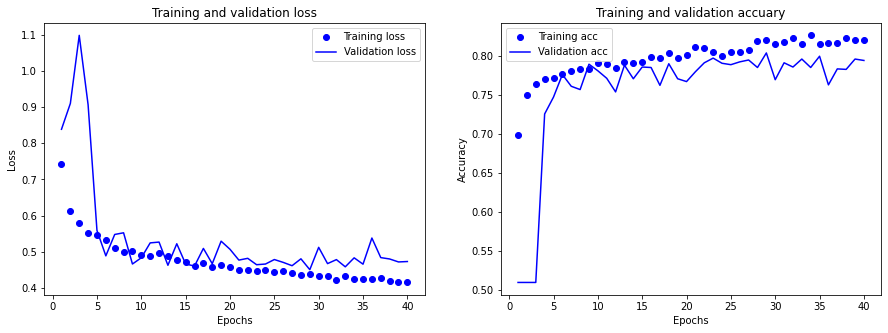

In [ ]:
history_dict = H.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuary')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()